# Классификация при помощи свёрточных нейронных сетей
Работа выполнена в рамках лабораторной работы по дисциплине Цифровая обработка изображений.



In [65]:
import numpy as np

import torch
from torch import nn
from torchvision.transforms import Resize
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryStatScores
from torch.optim import SGD
from torchinfo import summary

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from PIL import Image

from tqdm.auto import tqdm
from pathlib import Path
import time
import random

import matplotlib.pyplot as plt

Определим устройство, на котором будут проводиться все расчёты.

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Устройство: {device}.")
if device == 'cuda':
    !nvidia-smi

Устройство: cuda.
Mon May 20 11:20:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P8              9W /  170W |    5632MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------

# 1. Чтение данных
Данные подбирались вручную. Искались изображения лиц сов и яблок в разрезе по причине их высокой визуальной схожести. Было найдено по 20 изображений каждого класса.

## 1.1. Инициализация путей

In [67]:
# Пути до данных
path_dataset = Path("./data/L4")

# Пути до моделей
path_models = Path("./models/L4")
path_models.mkdir(parents=True, exist_ok=True)

## 1.2. Чтение изображений 

In [4]:
# Сначала определим все классы изображений и пути до них
class_path_dict = {}
for path in path_dataset.iterdir():
    if path.is_dir():
        class_path_dict[path.name] = Path(path)

print(f"Классы изображений: {class_path_dict.keys()}.")

Классы изображений: dict_keys(['apple', 'owl']).


Прочитаем все данные и сохраним их в два списка: данные и метки.

In [5]:
data_raw   = []
labels_raw = []
for class_name in class_path_dict:
    for img_path in class_path_dict[class_name].iterdir():
        data_raw.append(Image.open(img_path).convert('RGB'))
        labels_raw.append(class_name)

# 2. Предобработка
В данном разделе подведём все данные под формат, пригодный для библиотеки `pytorch`.

## 2.1. Кодирование меток
Данные сейчас имеют метки в формате строк. Необходимо их закодировать.

In [6]:
label_encoder = LabelEncoder()
label_encoder.fit(labels_raw)

target = label_encoder.transform(labels_raw)
target = torch.tensor(target).type(torch.float).to(device)

# Отображение кодирования
label_class_dict = {}
for class_name in label_encoder.classes_:
    label_class_dict[label_encoder.transform([class_name])[0]] = class_name

label_class_dict

{0: 'apple', 1: 'owl'}

## 2.2. Предобработка изображений
Единственная требуемая предобработка - это изменение размерности. Приведём все изображения к размерности 200х200.

In [7]:
IMAGE_SHAPE = (224, 224)

# Преобразование, которое будет использовано при инициализации датасетов
transform = Resize(IMAGE_SHAPE, antialias=None)

# Приведём к типу np.ndarray
data_arrays = [np.array(img) for img in data_raw]

# И применим преобразование
data = [np.transpose(arr, axes=[2, 0, 1]) for arr in data_arrays]
data = [transform(torch.tensor(arr)) for arr in data]
data = torch.tensor(np.array(data)).type(torch.float).to(device)

data.shape

torch.Size([40, 3, 224, 224])

In [8]:
def image_from_tensor(tensor : torch.Tensor) -> Image:
    tensor = torch.permute(tensor, [1, 2, 0])
    arr = tensor.cpu().numpy()
    return Image.fromarray(arr.astype(np.uint8))

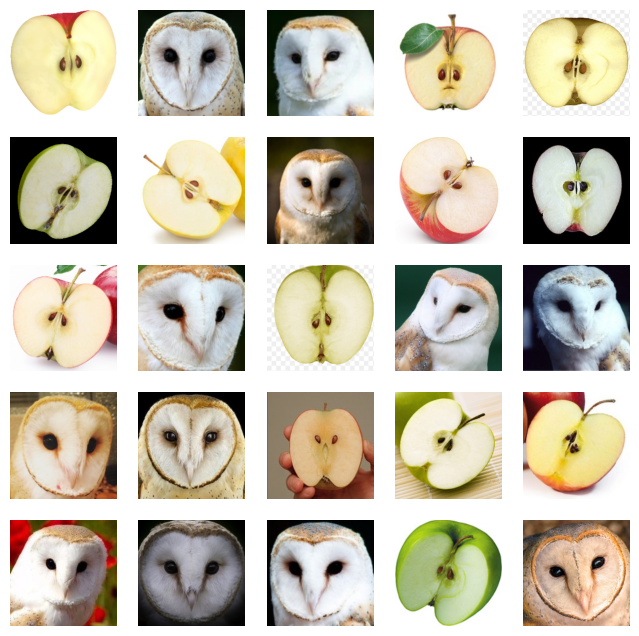

In [9]:
img_examples = random.sample(list(data), 25)

fig, axes = plt.subplots(5, 5, figsize=(8, 8))

for ax, img_tensor in zip(axes.flatten(), img_examples):
    ax.axis('off')
    ax.imshow(image_from_tensor(img_tensor))

## 2.3. Разделение на выборки


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

## 2.4. Инициализация датасета формата pytorch

In [11]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

Также потребуется сделать `dataloader`-ы.

In [12]:
BATCH_SIZE = 5

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader( test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 3. Модели нейронных сетей
В данном разделе создадим все тестируемые модели свёрточных нейронных сетей.

## 3.1. Простая свёрточная нейронная сеть
Ни ни что не опираясь, просто сделаем небольшую свёроточную сеть с не самым большим количеством параметров.

In [83]:
class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(40, 80, kernel_size=5, stride=2, padding=2)
        self.conv5 = nn.Conv2d(80, 160, kernel_size=5, stride=2, padding=2)
        self.relu = nn.ReLU()
        self.output_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(160 * 7 * 7, 1)
        )

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        res = self.relu(self.conv1(x))
        res = self.relu(self.conv2(res))
        res = self.relu(self.conv3(res))
        res = self.relu(self.conv4(res))
        res = self.relu(self.conv5(res))
        return self.output_layer(res)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_SimpleCNN = SimpleCNN().to(device)
summary(model_SimpleCNN)

Layer (type:depth-idx)                   Param #
SimpleCNN                                --
├─Conv2d: 1-1                            760
├─Conv2d: 1-2                            5,020
├─Conv2d: 1-3                            20,040
├─Conv2d: 1-4                            80,080
├─Conv2d: 1-5                            320,160
├─ReLU: 1-6                              --
├─Sequential: 1-7                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       7,841
Total params: 433,901
Trainable params: 433,901
Non-trainable params: 0

## 3.2. ResNet

In [84]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels : int, out_channels : int, stride : int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.shortcut = nn.Sequential() if in_channels == out_channels else nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        res = self.relu(self.bn1(self.conv1(x)))
        return self.relu(self.bn2(self.conv2(res)) + self.shortcut(x))

In [85]:
class ResNet(nn.Module):

    def __init__(self):
        super().__init__()
        # input: 3x224x224
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # input: 64x56x56
        self.stage_1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
        )

        # input: 64x56x56
        self.stage_2 = nn.Sequential(
            ResidualBlock(64, 128, 2),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
        )
        
        # input: 128x28x28
        self.stage_3 = nn.Sequential(
            ResidualBlock(128, 256, 2),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
        )
        
        # input: 256x14x14
        self.stage_4 = nn.Sequential(
            ResidualBlock(256, 512, 2),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
        )

        # input: 512x7x7
        self.output_layer = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=7, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        res = self.input_layer(x)
        res = self.stage_1(res)
        res = self.stage_2(res)
        res = self.stage_3(res)
        res = self.stage_4(res)
        return self.output_layer(res)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_ResNet = ResNet().to(device)
summary(model_ResNet)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,472
│    └─MaxPool2d: 2-2                    --
├─Sequential: 1-2                        --
│    └─ResidualBlock: 2-3                --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─Conv2d: 3-2                  36,864
│    │    └─BatchNorm2d: 3-3             128
│    │    └─BatchNorm2d: 3-4             128
│    │    └─ReLU: 3-5                    --
│    │    └─Sequential: 3-6              --
│    └─ResidualBlock: 2-4                --
│    │    └─Conv2d: 3-7                  36,864
│    │    └─Conv2d: 3-8                  36,864
│    │    └─BatchNorm2d: 3-9             128
│    │    └─BatchNorm2d: 3-10            128
│    │    └─ReLU: 3-11                   --
│    │    └─Sequential: 3-12             --
│    └─ResidualBlock: 2-5                --
│    │    └─Conv2d: 3-13                 36,864


## 3.3. XResNet

In [93]:
class XResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
        
        self.shortcut = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
        ) if in_channels != out_channels else nn.Sequential()

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        res = self.relu(self.bn1(self.conv1(x)))
        res = self.relu(self.bn2(self.conv2(res)))
        return self.relu(self.bn3(self.conv3(res)) + self.shortcut(x))

In [94]:
class XResNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.input_stage = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.stage1 = nn.Sequential(
            XResidualBlock(64, 64),
            XResidualBlock(64, 64),
            XResidualBlock(64, 64),
            XResidualBlock(64, 64),
        )
        self.stage2 = nn.Sequential(
            XResidualBlock(64, 128, 2),
            XResidualBlock(128, 128),
            XResidualBlock(128, 128),
            XResidualBlock(128, 128),
        )
        self.stage3 = nn.Sequential(
            XResidualBlock(128, 256, 2),
            XResidualBlock(256, 256),
            XResidualBlock(256, 256),
            XResidualBlock(256, 256),
        )
        self.stage4 = nn.Sequential(
            XResidualBlock(256, 512, 2),
            XResidualBlock(512, 512),
            XResidualBlock(512, 512),
            XResidualBlock(512, 512),
        )
        self.output_stage = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=7, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        res = self.input_stage(x)
        res = self.stage1(res)
        res = self.stage2(res)
        res = self.stage3(res)
        res = self.stage4(res)
        return self.output_stage(res)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_XResNet = XResNet().to(device)
summary(model_XResNet)

Layer (type:depth-idx)                   Param #
XResNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─Conv2d: 2-2                       36,928
│    └─Conv2d: 2-3                       36,928
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─XResidualBlock: 2-5               --
│    │    └─Conv2d: 3-1                  4,160
│    │    └─Conv2d: 3-2                  36,928
│    │    └─Conv2d: 3-3                  4,160
│    │    └─BatchNorm2d: 3-4             128
│    │    └─BatchNorm2d: 3-5             128
│    │    └─BatchNorm2d: 3-6             128
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              --
│    └─XResidualBlock: 2-6               --
│    │    └─Conv2d: 3-9                  4,160
│    │    └─Conv2d: 3-10                 36,928
│    │    └─Conv2d: 3-11                 4,160
│    │    └─BatchNorm2d: 3-12        

# 4. Обучение моделей
Так как мы имеем на руках проблему бинарной классификации, то и в качестве алгоритма обучения будет использован стохастический градиентный спуск, а в качестве критерия - бинарная кросс-энтропия.

## 4.1. Процедура обучения моделей

In [88]:
def train_model(
    model : torch.nn.Module,  # Обучаемая модель
    trainloader : DataLoader, # Загрузчик обучающей выборки
    testloader : DataLoader,  # Загрузчик тестовой выборки
    epochs : int = 1000,      # Количество эпох обучения
    lr : float = 0.001,       # Скорость обучения
    momentum : float = 0.9,   # Моментум
    random_state : int = 42   # семя случайностей
):
    torch.manual_seed(random_state)
    torch.cuda.manual_seed(random_state)
    random.seed(random_state)
    
    # Метрики
    accuracy_fn   = BinaryAccuracy().to(device)
    statscores_fn = BinaryStatScores().to(device)

    # Критерий и алггоритм оптимизации
    criterion = nn.BCELoss()
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)

    report_epochs = epochs // 10
    if report_epochs == 0:
        report_epochs = epochs
    
    losses     = np.zeros(epochs)
    accuracies = np.zeros(epochs)
    statscores = np.zeros((epochs, 5))
    
    epoch_total = epochs
    
    start_time = time.time()
    prev_time  = start_time
    
    for epoch in tqdm(range(epochs)):
        # Шаг обучения модели
        model.train()
        for inputs, labels in trainloader:
            logits = model(inputs).squeeze()
            y_preds = torch.sigmoid(logits)
            loss = criterion(y_preds, labels)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Оценивание метрик модели на текущем шаге
        model.eval()
        with torch.inference_mode():
            test_loss = 0
            accuracy  = 0
            statscore = torch.tensor([0, 0, 0, 0, 0]).to(device)
            
            for inputs, labels in testloader:
                logits      = model(inputs).squeeze()
                test_preds  = torch.sigmoid(logits)
                test_labels = torch.round(test_preds)

                test_loss += criterion(test_preds, labels)
                accuracy  += accuracy_fn(test_labels, labels)
                statscore += statscores_fn(test_labels, labels)

            test_loss /= len(testloader)
            accuracy  /= len(testloader)
            
            losses[epoch]     = test_loss
            accuracies[epoch] = accuracy
            statscores[epoch] = statscore.cpu().numpy()

            # Остановить обучение, если началось переобучение
            if epoch >= 40 and np.mean(losses[epoch - 40 : epoch - 20]) < np.mean(losses[epoch - 20 : epoch]):
                current_time = time.time()
                
                losses     = losses[:epoch + 1]
                accuracies = accuracies[:epoch + 1]
                statscores = statscores[:epoch + 1]

                epoch_total = epoch + 1

                print(f"[Эпоха: {epoch + 1:4d}] Ошибка: {test_loss:.6f} | Точность: {accuracy * 100:9.6f} % "
                      f"| Время выполнения {(epoch + 1) % report_epochs:6d} эпох: {current_time - prev_time:11.6f} секунд")
                print(f"Обучение прервано по причине начала переобучения на {epoch + 1:6d} эпохе.")
                break
        
            if epoch % report_epochs == report_epochs - 1:
                current_time = time.time()
                print(f"[Эпоха: {epoch + 1:4d}] Ошибка: {test_loss:.6f} | Точность: {accuracy * 100:9.6f} % "
                      f"| Время выполнения {report_epochs:6d} эпох: {current_time - prev_time:11.6f} секунд")
                prev_time = current_time
    
    end_time = time.time()
    print(f"Итоговое время расчёта: {end_time - start_time:11.6f} секунд.")

    return (
        losses,
        accuracies,
        statscores,
        epoch_total
    )

## 4.2. Обучение моделей

In [89]:
epochs = 100
learning_rate = 0.001
momentum = 0.9

In [90]:
loss_SimpleCNN, acc_SimpleCNN, stats_SimpleCNN, epochs_SimpleCNN = train_model(model_SimpleCNN, train_loader, test_loader, epochs, lr=learning_rate, momentum=momentum)

  0%|          | 0/100 [00:00<?, ?it/s]

[Эпоха:   10] Ошибка: 0.630974 | Точность: 80.000000 % | Время выполнения     10 эпох:    0.363383 секунд
[Эпоха:   20] Ошибка: 0.508878 | Точность: 90.000000 % | Время выполнения     10 эпох:    0.203601 секунд
[Эпоха:   30] Ошибка: 10.414451 | Точность: 80.000000 % | Время выполнения     10 эпох:    0.195681 секунд
[Эпоха:   40] Ошибка: 10.194022 | Точность: 80.000000 % | Время выполнения     10 эпох:    0.202147 секунд
[Эпоха:   41] Ошибка: 10.195689 | Точность: 80.000000 % | Время выполнения      1 эпох:    0.022240 секунд
Обучение прервано по причине начала переобучения на     41 эпохе.
Итоговое время расчёта:    0.990043 секунд.


In [91]:
loss_ResNet, acc_ResNet, stats_ResNet, epochs_ResNet = train_model(model_ResNet, train_loader, test_loader, epochs, lr=learning_rate, momentum=momentum)

  0%|          | 0/100 [00:00<?, ?it/s]

[Эпоха:   10] Ошибка: 0.686269 | Точность: 90.000000 % | Время выполнения     10 эпох:    1.898902 секунд
[Эпоха:   20] Ошибка: 0.786328 | Точность: 90.000000 % | Время выполнения     10 эпох:    1.921402 секунд
[Эпоха:   30] Ошибка: 0.738289 | Точность: 90.000000 % | Время выполнения     10 эпох:    1.895356 секунд
[Эпоха:   40] Ошибка: 0.872295 | Точность: 90.000000 % | Время выполнения     10 эпох:    1.907940 секунд
[Эпоха:   43] Ошибка: 0.823101 | Точность: 90.000000 % | Время выполнения      3 эпох:    0.570673 секунд
Обучение прервано по причине начала переобучения на     43 эпохе.
Итоговое время расчёта:    8.197446 секунд.


In [95]:
loss_XResNet, acc_XResNet, stats_XResNet, epochs_XResNet = train_model(model_XResNet, train_loader, test_loader, epochs, lr=learning_rate, momentum=momentum)

  0%|          | 0/100 [00:00<?, ?it/s]

[Эпоха:   10] Ошибка: 0.288982 | Точность: 80.000000 % | Время выполнения     10 эпох:    2.111361 секунд
[Эпоха:   20] Ошибка: 1.016693 | Точность: 70.000008 % | Время выполнения     10 эпох:    1.874538 секунд
[Эпоха:   30] Ошибка: 0.478925 | Точность: 80.000000 % | Время выполнения     10 эпох:    1.872397 секунд
[Эпоха:   40] Ошибка: 0.649553 | Точность: 80.000000 % | Время выполнения     10 эпох:    1.873406 секунд
[Эпоха:   47] Ошибка: 0.456019 | Точность: 80.000000 % | Время выполнения      7 эпох:    1.309816 секунд
Обучение прервано по причине начала переобучения на     47 эпохе.
Итоговое время расчёта:    9.043540 секунд.


# 5. Оценка результатов

In [50]:
# Сделаем "локализацию" для меток
localization_dict = {
    'owl'   : ['сова', 'совы'],
    'apple' : ['яблоко', 'яблоки'],
}

In [51]:
def print_results(losses, accuracies, statscores, epochs_total, model):
    fig, axes = plt.subplots(2, 2, figsize=(15, 7), layout='constrained')

    plt.suptitle(
        f"Метрики за {epochs_total} эпох обучения модели {model.__class__.__name__}\n"
        f"[Классификация 1 - {localization_dict[label_class_dict[1]][0]}, 0 - {localization_dict[label_class_dict[0]][0]}]"
    )
    
    for axes_row in axes:
        for ax in axes_row:
            ax.set_xlabel("Эпоха")
            ax.grid()
    
    axes[0][0].plot(losses)
    axes[0][0].set_title("Функция потерь (Бинарная кросс-энтропия)")
    axes[0][0].set_ylabel("Ошибка")
    
    axes[0][1].plot(accuracies)
    axes[0][1].set_title("Точность")
    axes[0][1].set_ylabel("Точность")
    
    axes[1][0].plot(statscores[:, 1])
    axes[1][0].set_title(f"Ошибка первого рода (неверно определённые {localization_dict[label_class_dict[1]][1]})")
    axes[1][0].set_ylabel("Количество ложных срабатываний")
    
    axes[1][1].plot(statscores[:, 3])
    axes[1][1].set_title(f"Ошибка второго рода (неверно определённые {localization_dict[label_class_dict[0]][1]}))")
    axes[1][1].set_ylabel("Количество ложных срабатываний")
    
    plt.show()

## 5.1. Простая CNN

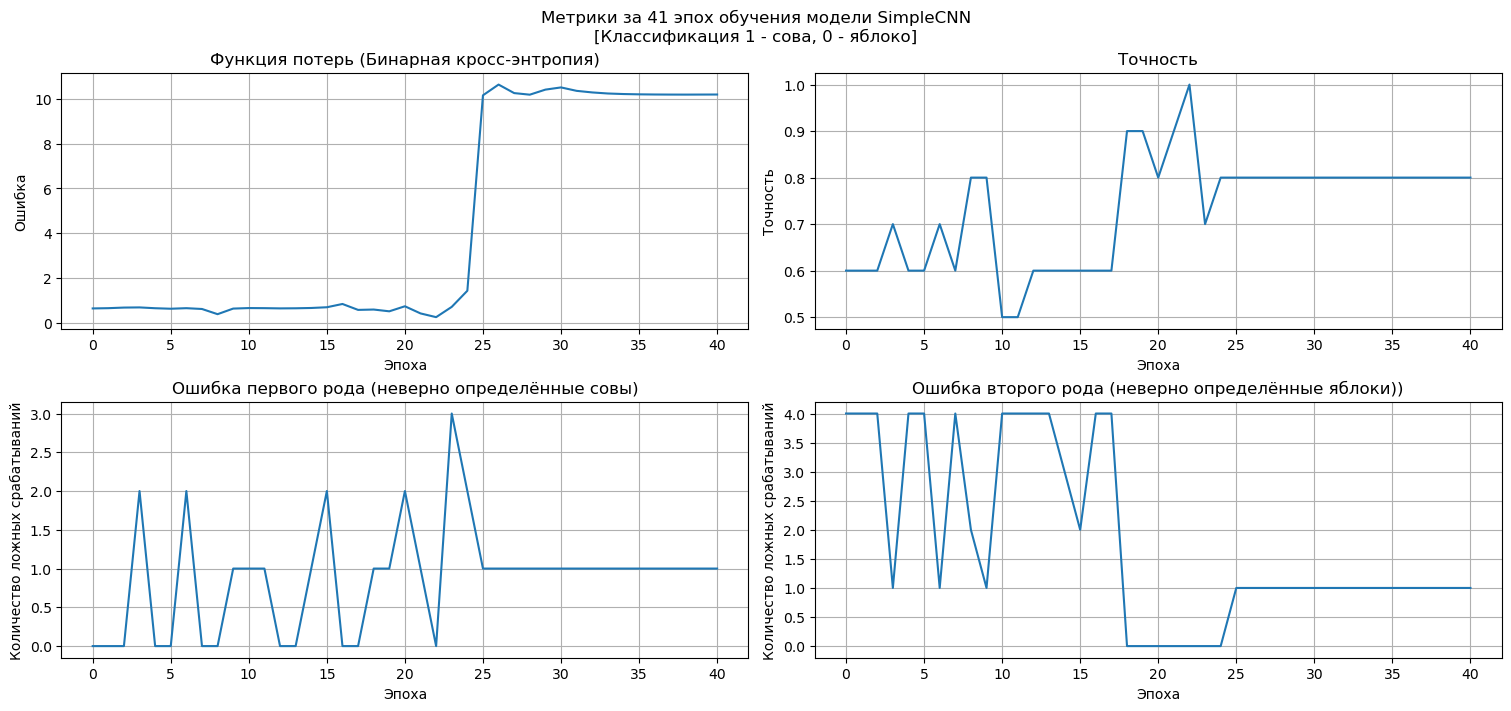

In [97]:
print_results(loss_SimpleCNN, acc_SimpleCNN, stats_SimpleCNN, epochs_SimpleCNN, model_SimpleCNN)

## 5.2. ResNet

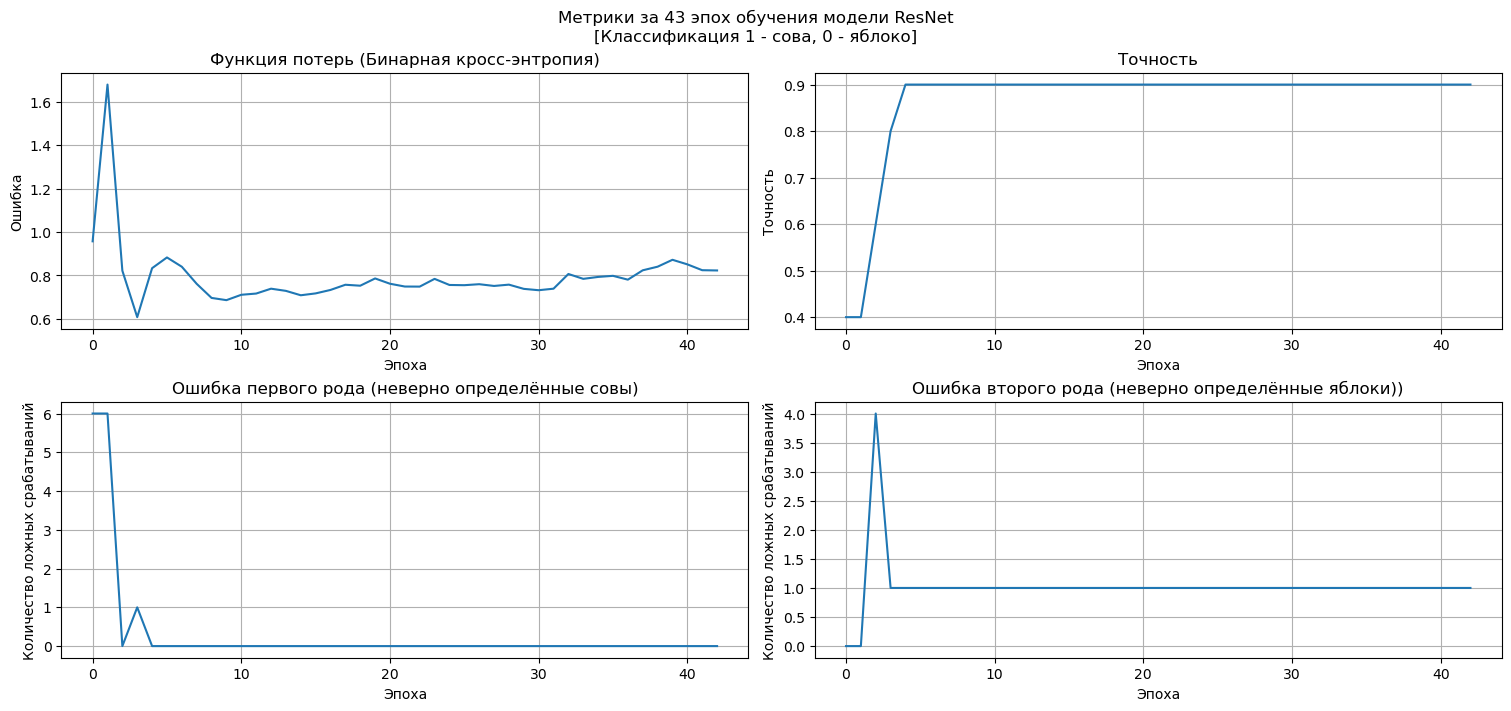

In [98]:
print_results(loss_ResNet, acc_ResNet, stats_ResNet, epochs_ResNet, model_ResNet)

## 5.3. XResNet

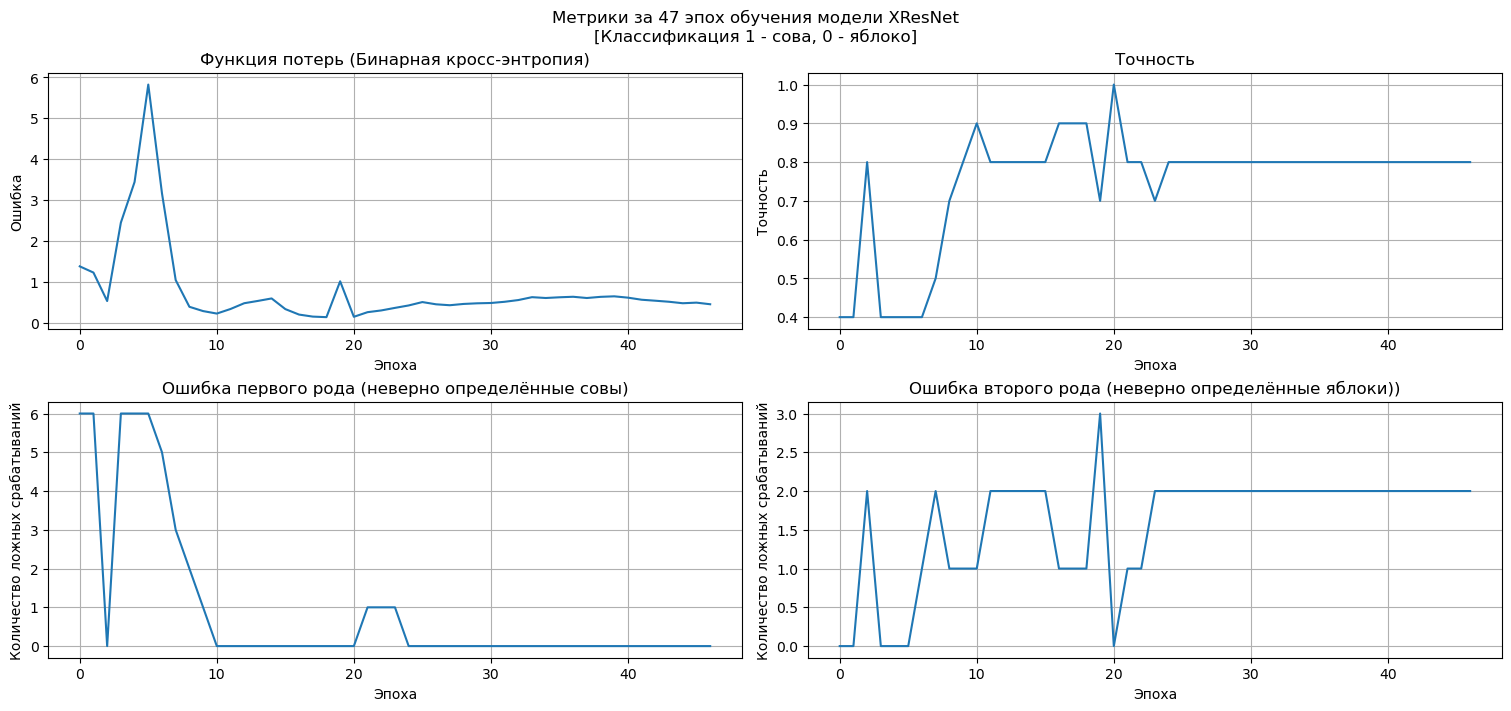

In [99]:
print_results(loss_XResNet, acc_XResNet, stats_XResNet, epochs_XResNet, model_XResNet)

# 6. Демонстрация лучшей модели

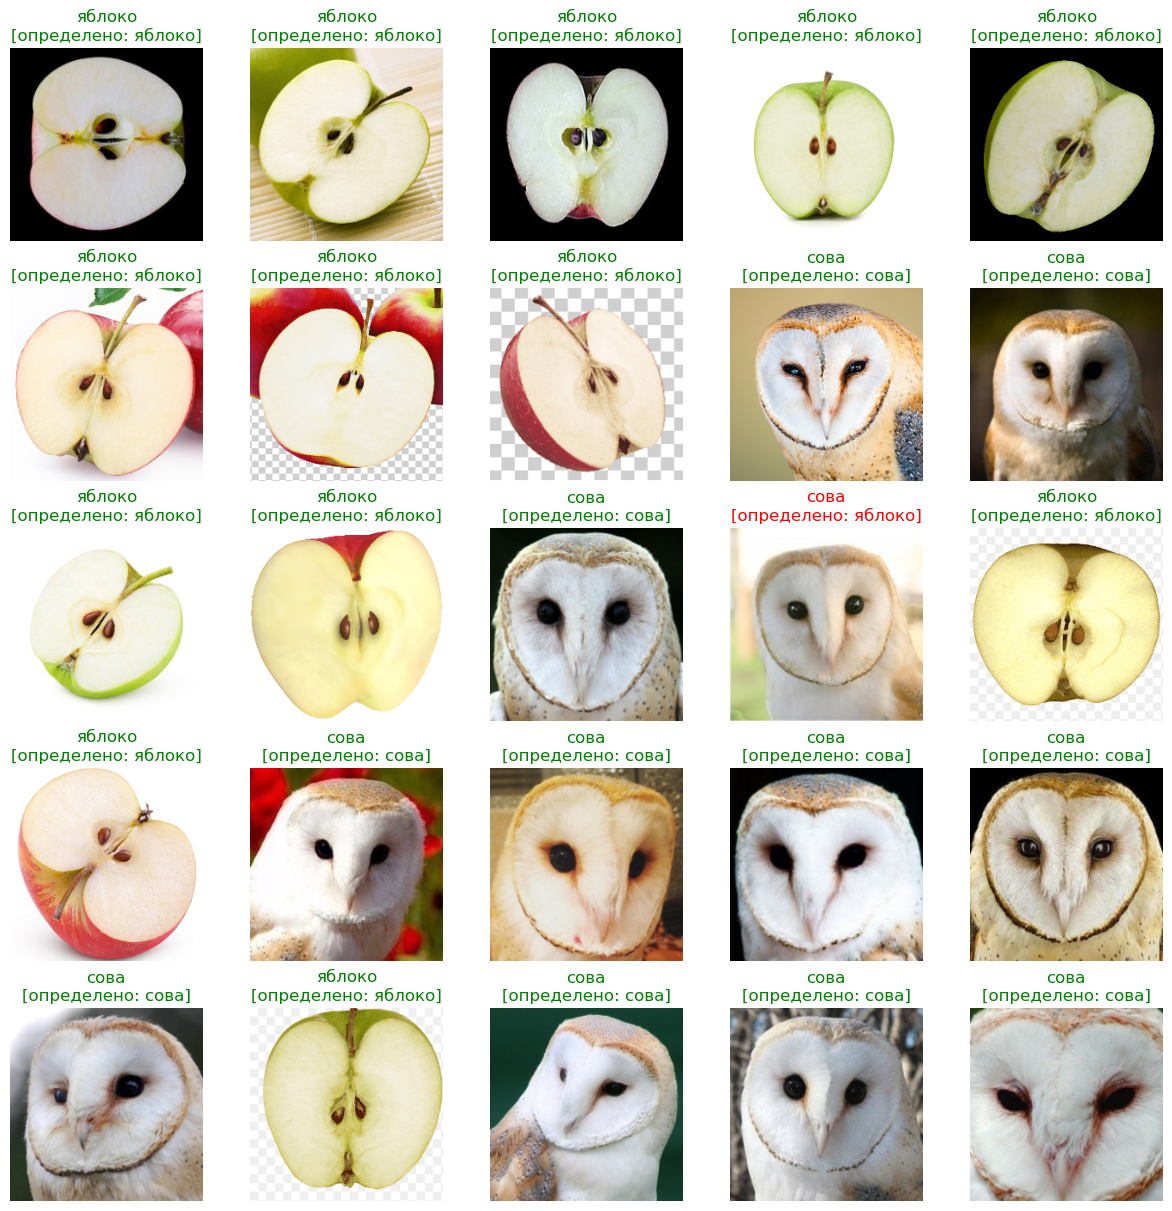

In [100]:
best_model = model_ResNet

# Отберём 25 изображений для демонстрации
samples = random.sample(list(zip(list(data), list(target))), 25)
samples_data   = torch.tensor(np.array([sample[0].cpu() for sample in samples])).to(device)
samples_target = [sample[1].type(torch.int).cpu().numpy().item() for sample in samples]

# Выполним классификацию
samples_logits = best_model(samples_data).squeeze()
samples_preds  = torch.sigmoid(samples_logits)
samples_labels = torch.round(samples_preds).type(torch.int).cpu().numpy()

fig, axes = plt.subplots(5, 5, figsize=(12, 12), layout='constrained')

for ax, img_tensor, label, prediction in zip(axes.flatten(), samples_data, samples_target, samples_labels):
    ax.axis('off')
    ax.imshow(image_from_tensor(img_tensor))
    ax.set_title(
        f"{localization_dict[label_class_dict[label]][0]}\n[определено: {localization_dict[label_class_dict[prediction]][0]}]",
        color = 'green' if prediction == label else 'red'
    )